---
format: 
  html:
    toc: true
    page-layout: full
execute:
    warning: false
    echo: true
    eval: true
---

# Seasonal Prevalence Estimation and Dimensionality Reduction

This short Python notebook aims to estimate the seasonal prevalence of Chronic Obstructive Pulmonary Disease (COPD) and examine multicollinearity among predictor variables. Our current dataset calculates COPD on an annual basis; however, seasonal variations can significantly affect local environmental conditions, which may, in turn, influence COPD rates. To address this, we have acquired vegetation indices from different seasons, but at the same time, we also need an estimate of COPD rate for each season. We will split our dataframe into four separate dataframes—one for each season—and running machine learning models on these subsets. This approach avoids the potential errors introduced by averaging vegetation indices over an entire year. Additionally, dimensionality reduction is essential as many variables in our dataset may be highly correlated, leading to multicollinearity issues. For this analysis, we will only require the `geopandas`, `pandas`, and `sklearn` libraries.

In [20]:
#| code-fold: true

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

In [2]:
#| echo: false

PA_Final = pd.read_csv('../data/Intermediaries/PA_Final.csv')

## Seasonal Prevalence

The approach we took here to estimate seasonal prevalence of COPD based on annual data is to look for exisiting literatures. In a study by So, Jennifer Y et al (2018), they analyzed data from 1,175 subjects without cardiovascular risk factors, and investigated seasonal and regional variability in COPD exacerbations across 45 study sites in North America. The results showed that winter had the highest COPD exacerbation rate (0.13 exacerbations/person-month), significantly greater than spring, summer, and fall (0.11, 0.079, and 0.10 exacerbations/person-month, respectively; P < 0.001). This is not suprising result, as colder temperatures are known to increase hospitalization and mortality rates in adults with COPD and cardiac conditions, but the exacerbation rate they computed can be a helpful resource for us to compute a seasonal estimate. Their full article is avaialable [here](https://pmc.ncbi.nlm.nih.gov/articles/PMC6322011/#sec4).

**Rates of exacerbations in each season in each region**

![](../assets/ex-rate.png)
*Source: So, Jennifer Y et al (2018)*

Based on these information, the function `calculate_seasonal_exacerbations` first normalizes the input seasonal rates by dividing each rate by the total of all rates, ensuring they sum to 1. This normalization ensures that the rates are proportional and can be directly applied to the data. Next, for each season, the function calculates the number of seasonal exacerbations (season_count) for each row by multiplying the total COPD cases (total_column) by the normalized seasonal rate. It also computes the seasonal exacerbation rate as a percentage of the total population (season_rate).

In [3]:
def calculate_seasonal_exacerbations(df, total_column, seasonal_rates):

    # Normalize the seasonal rates
    total_rate = sum(seasonal_rates.values())
    normalized_rates = {season: rate / total_rate for season, rate in seasonal_rates.items()}
    
    # Calculate seasonal exacerbations for each row in the DataFrame
    for season, rate in normalized_rates.items():
        df[f'{season}_count'] = df[total_column] * rate
        df[f'{season}_rate'] = df[f'{season}_count'] / df['TotalPopulation'] * 100

    return df

The seasonal rates are predefined as 0.39 for winter, 0.33 for spring, 0.237 for summer, and 0.30 for fall, based on observed data. Before calling the function, the total number of COPD-affected individuals is calculated for each row by converting the COPD rate from a percentage to an absolute count using the population column (TotalPopulation). This adjusted dataset is then processed by the function to estimate the seasonal COPD exacerbations for the population in Pennsylvania `PA_Final`.

In [4]:
seasonal_rates = {
    'winter': 0.39,  # Winter rate
    'spring': 0.33,  # Spring rate
    'summer': 0.237, # Summer rate
    'fall': 0.30     # Fall rate
}

PA_Final["COP_People"] = PA_Final["COP"] / 100 * PA_Final["TotalPopulation"]
PA_Final = calculate_seasonal_exacerbations(PA_Final, 'COP_People', seasonal_rates)

After all these, we proceed to create separate dataframe for each season. As an example, `PA_Spring` contains selected columns relevant to the analysis of COPD exacerbations during the spring season. This includes demographic, behavioral, and environmental variables such as Asthma, Smoking, forest_pct, lst_spring, and others, along with spring-specific exacerbation metrics (spring_count and spring_rate). These variables allow for targeted analysis of seasonal factors influencing COPD in spring. This process is repeated similarly for the other three seasons (winter, summer, and fall), with the corresponding seasonal columns (e.g., winter_count, lst_winter, etc.) included in their respective DataFrames. This separation enables season-specific analysis while maintaining consistency in the variables studied.

In [5]:
#| code-fold: true

# spring dataframe
PA_Spring = PA_Final[['CountyName', 'Asthma', 'TotalPopulation', 'COP', 'GEOID', 'Smoking', 
                      'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                      'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                      'evi_spring','lst_spring', 'ndvi_spring', 'savi_spring', 'spring_count', "spring_rate"]]

In [6]:
#| echo: false

# summer dataframe 
PA_Summer = PA_Final[['CountyName', 'Asthma', 'TotalPopulation', 'COP', 'GEOID', 'Smoking', 
                      'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                      'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                      'evi_summer','lst_summer', 'ndvi_summer', 'savi_summer', 'summer_count', "summer_rate"]]

In [7]:
#| echo: false

# fall dataframe
PA_Fall = PA_Final[['CountyName', 'Asthma', 'TotalPopulation', 'COP', 'GEOID', 'Smoking', 
                      'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                      'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                      'evi_fall','lst_fall', 'ndvi_fall', 'savi_fall', 'fall_count', "fall_rate"]]

In [8]:
#| echo: false

# winter dataframe
PA_Winter = PA_Final[['CountyName', 'Asthma', 'TotalPopulation', 'COP', 'GEOID', 'Smoking', 
                      'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                      'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                      'evi_winter','lst_winter', 'ndvi_winter', 'savi_winter', 'winter_count', "winter_rate"]]

## Dimensionality Reduction

Dimensionality reduction is an important step before runing any machine learning models because many of the predictor variables are likely to be correlated with each other, which can lead to multicollinearity. Multicollinearity occurs when two or more predictors in a model are highly correlated, making it difficult to determine the individual effect of each predictor on the target variable. This can result in unstable coefficient estimates, increased variance, and reduced model interpretability.

For instance, environmental factors such as `forest_total`, `wetland_total`, and `grasses_total` may exhibit correlations, while demographic variables like `minority`, `aging`, and `disability` could also be related. Multicollinearity makes it difficult to isolate the effect of each individual predictor on the target variable, potentially destabilizing model estimates. Additionally, some variables like `Hdensity_total` and `Ldensity_total`, or the vegetation indices `evi_spring`, `ndvi_spring`, `savi_spring`, may be redundant and provide overlapping information, which increases the model's complexity without adding predictive value. This redundancy and high correlation among predictors increase the risk of overfitting, where the model captures noise rather than true patterns in the data. 

Indeed, upon checking the correlation matrix for all of our variables, we found that there's strong correlation between between vegetation indicies, different land cover features, and different health risks behaviors. Including all of them in our model will lead to overfitting.

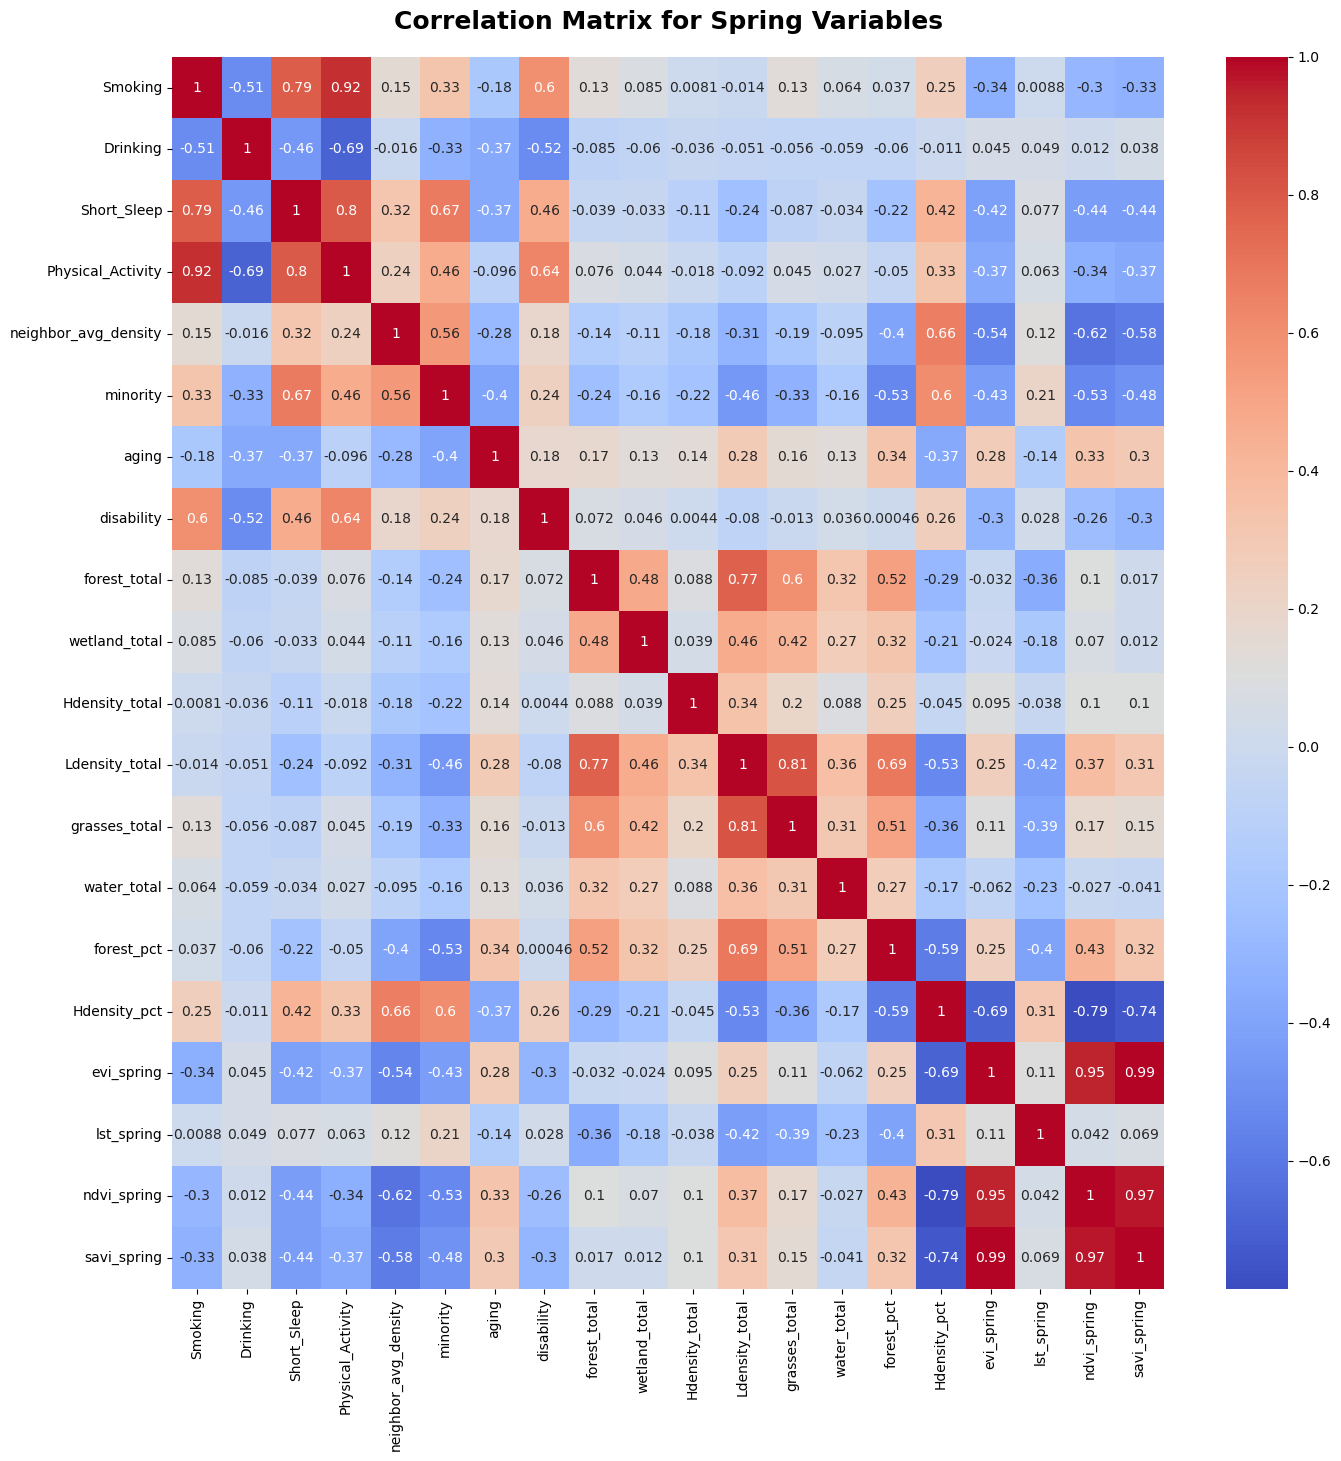

In [29]:
#| echo: false
spring_corr = PA_Spring[['Smoking', 
                      'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                      'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                      'evi_spring','lst_spring', 'ndvi_spring', 'savi_spring']]

plt.figure(figsize=(16, 16)) 
plt.title("Correlation Matrix for Spring Variables", fontsize=18, pad=20, fontweight='bold')

ax = sns.heatmap(spring_corr.corr(), annot=True, cmap="coolwarm")
plt.show()

In [27]:
feature_columns  = ['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                    'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_spring','lst_spring', 'ndvi_spring', 'savi_spring']
target_column = "spring_rate"

X = PA_Spring[feature_columns]
y = PA_Spring[target_column]

Now, we will apply linear regression using the scikit-learn library to perform dimensionality reduction by calculating the Bayesian Information Criterion (BIC), using the spring dataset as an example. The BIC will help identify the most relevant predictor variables, mitigating the impact of multicollinearity and enhancing the interpretability of our machine learning models.

The **Bayesian Information Criterion (BIC)** is a model selection criterion that balances the goodness of fit with the complexity of the model. It is particularly useful for dimensionality reduction, as it helps penalize the inclusion of irrelevant predictor variables. The formula for BIC is:

$$
\text{BIC} = n \cdot \log(\text{MSE}) + p \cdot \log(n)
$$

Where n is the number of samples, MSE is the mean squared error (a measure of model fit), and p is the number of predictors in the model.


The BIC penalizes models with more parameters to avoid overfitting, encouraging the selection of simpler models that still provide a good fit. The following code uses BIC to perform dimensionality reduction and eliminate irrelevant predictors from the model. The first step in the code is to fit the **full model** using all available predictors (`X`). The model is trained using `LinearRegression()` from `scikit-learn`, and the predictions (`y_pred_full`) are generated. The BIC for this full model is then calculated.

Next, the code performs backward elimination to reduce the number of predictors. It starts with all predictors in the model and iteratively removes the least significant predictors based on BIC.
- For each iteration, the BIC for models excluding one predictor at a time is calculated.
- If removing a predictor results in a lower BIC (indicating a better model with fewer predictors), the predictor is excluded from the model.
- This process continues until no further improvement in BIC is achieved by removing predictors.


In [21]:
def calculate_bic(y_true, y_pred, n, p):
    """Calculate Bayesian Information Criterion (BIC)."""
    mse = mean_squared_error(y_true, y_pred)
    return n * np.log(mse) + p * np.log(n)

# Step 1: Fit the full model
full_model = LinearRegression().fit(X, y)
y_pred_full = full_model.predict(X)
n_samples = len(y)
p_predictors = X.shape[1]
bic_full = calculate_bic(y, y_pred_full, n_samples, p_predictors)

# Step 2: Perform backward elimination
selected_predictors = list(X.columns)
selected_bic = bic_full

while True:
    best_bic = selected_bic
    best_predictors = selected_predictors

    for predictor in selected_predictors:
        predictors_subset = selected_predictors.copy()
        predictors_subset.remove(predictor)
        X_subset = X[predictors_subset]
        model = LinearRegression().fit(X_subset, y)
        y_pred_subset = model.predict(X_subset)
        bic = calculate_bic(y, y_pred_subset, n_samples, len(predictors_subset))
        if bic < best_bic:
            best_bic = bic
            best_predictors = predictors_subset

    if best_bic < selected_bic:
        selected_bic = best_bic
        selected_predictors = best_predictors
    else:
        break

# Print the selected predictors and their BIC
print("Selected predictors:", selected_predictors)
print("BIC:", selected_bic)

Selected predictors: ['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'minority', 'aging', 'disability', 'forest_total', 'Ldensity_total', 'grasses_total', 'forest_pct', 'lst_spring']
BIC: -12292.878498899865


The backward elimination procedure identified the following **selected predictors** as those contributing most significantly to the model's fit while minimizing the BIC:

- **Smoking**: The smoking rate in the population.
- **Drinking**: The alcohol consumption rate in the population.
- **Short_Sleep**: The proportion of the population reporting insufficient sleep.
- **Physical_Activity**: The level of physical activity in the population.
- **minority**: The proportion of the population belonging to minority groups.
- **aging**: The aging population within the dataset.
- **disability**: The proportion of the population with disabilities.
- **forest_total**: Total forested area in the region.
- **Ldensity_total**: Total land density (likely referring to residential or urban areas).
- **grasses_total**: Total grassland area in the region.
- **forest_pct**: The percentage of the region covered by forests.
- **lst_spring**: Land Surface Temperature (LST) for the spring season.

These predictors have been retained because their inclusion resulted in the **lowest Bayesian Information Criterion (BIC)** value. The BIC for this model is **-12292.88**, indicating the best balance between goodness of fit and model complexity among the models tested.

This model is optimal in terms of fitting the data without overfitting, as indicated by the negative BIC value, which is lower compared to other possible models with more predictors.